
===== SARIMAX MODEL SUMMARY (National) =====
                                     SARIMAX Results                                     
Dep. Variable:                          National   No. Observations:                  240
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -727.281
Date:                           Fri, 30 Jan 2026   AIC                           1464.563
Time:                                   09:38:31   BIC                           1481.599
Sample:                                        0   HQIC                          1471.440
                                           - 240                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0317      0.072      0.438      0.661      -0.110       0.1

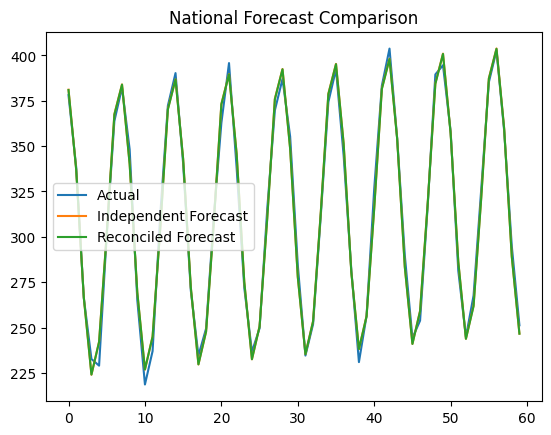

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# ===============================
# 1. SYNTHETIC HIERARCHICAL DATA
# ===============================
np.random.seed(42)

n = 300
time = np.arange(n)

seasonality = 20 * np.sin(2 * np.pi * time / 7)
trend = 0.1 * time

region_1 = 50 + trend + seasonality + np.random.normal(0, 3, n)
region_2 = 40 + trend + seasonality + np.random.normal(0, 3, n)
region_3 = 60 + trend + seasonality + np.random.normal(0, 3, n)
region_4 = 55 + trend + seasonality + np.random.normal(0, 3, n)

national = region_1 + region_2 + region_3 + region_4

data = pd.DataFrame({
    "National": national,
    "Region_1": region_1,
    "Region_2": region_2,
    "Region_3": region_3,
    "Region_4": region_4
})

# ===============================
# 2. TRAIN / TEST SPLIT
# ===============================
train_size = int(0.8 * n)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# ===============================
# 3. SARIMAX – NATIONAL MODEL
# ===============================
model_nat = SARIMAX(
    train["National"],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

result_nat = model_nat.fit(disp=False)

print("\n===== SARIMAX MODEL SUMMARY (National) =====")
print(result_nat.summary())

# ===============================
# 4. FORECAST NATIONAL
# ===============================
forecast_nat = result_nat.forecast(len(test))

rmse_nat = np.sqrt(mean_squared_error(test["National"], forecast_nat))
mape_nat = np.mean(np.abs((test["National"] - forecast_nat) / test["National"])) * 100

# ===============================
# 5. SARIMAX – REGIONAL MODELS
# ===============================
region_forecasts = {}
rmse_independent = []

for region in ["Region_1", "Region_2", "Region_3", "Region_4"]:
    model = SARIMAX(
        train[region],
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)
    forecast = result.forecast(len(test))
    region_forecasts[region] = forecast
    rmse_independent.append(
        np.sqrt(mean_squared_error(test[region], forecast))
    )

# ===============================
# 6. BOTTOM-UP RECONCILIATION
# ===============================
reconciled_national = (
    region_forecasts["Region_1"]
    + region_forecasts["Region_2"]
    + region_forecasts["Region_3"]
    + region_forecasts["Region_4"]
)

rmse_reconciled = np.sqrt(
    mean_squared_error(test["National"], reconciled_national)
)

mape_reconciled = np.mean(
    np.abs((test["National"] - reconciled_national) / test["National"])
) * 100

# ===============================
# 7. RESULTS
# ===============================
print("\n===== FORECAST ACCURACY =====")
print(f"Independent National Forecast RMSE: {rmse_nat:.2f}")
print(f"Independent National Forecast MAPE: {mape_nat:.2f}%")

print(f"Bottom-Up Reconciled RMSE: {rmse_reconciled:.2f}")
print(f"Bottom-Up Reconciled MAPE: {mape_reconciled:.2f}%")

# ===============================
# 8. FINAL 30-STEP FORECAST
# ===============================
steps = 30
final_forecasts = {}

for col in data.columns:
    model = SARIMAX(
        data[col],
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)
    final_forecasts[col] = result.forecast(steps)

print("\n===== 30 STEP AHEAD FORECAST =====")
for k, v in final_forecasts.items():
    print(f"\n{k}:")
    print(np.round(v.values, 2))

# ===============================
# 9. PLOTS
# ===============================
plt.figure()
plt.plot(test["National"].values, label="Actual")
plt.plot(forecast_nat.values, label="Independent Forecast")
plt.plot(reconciled_national.values, label="Reconciled Forecast")
plt.legend()
plt.title("National Forecast Comparison")
plt.show()
